### 作业三


##### 一、将`underfit-overfit.ipynb`中的神经网络`net`通过继承`nn.Modual`的方式改为一个包含三个隐藏层(权重层)的MLP,其中激活函数为`ReLU()`,观察测试结果。

weight: [[ 5.015246    1.2515091  -3.3910193   5.4347076  -0.19646531  0.41538787
   0.6304519  -0.31658378  0.15613592 -0.04861782 -0.07734938  0.01699765
   0.21475893  0.13436428  0.20636235  0.06187087  0.18530358  0.10698448
  -0.19811305  0.19984902]]


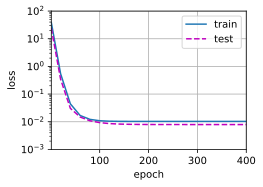

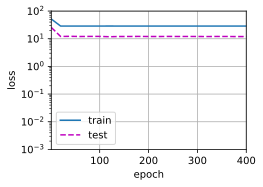

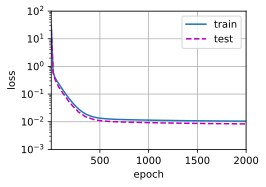

In [4]:
import math
import numpy as np
import torch
from IPython import display
from d2l import torch as d2l
from torch import nn

class Animator:
    """在动画中绘制数据"""

    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):

        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]

        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


class Accumulator:
    """在n个变量上累加"""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）"""
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):

            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:

            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    return metric[0] / metric[2], metric[1] / metric[2]


max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

true_w, features, poly_features, labels = [torch.tensor(x, dtype=
torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.hidden1 = nn.Linear(input_shape, hidden_units[0])
        self.hidden2 = nn.Linear(hidden_units[0], hidden_units[1])
        self.hidden3 = nn.Linear(hidden_units[1], hidden_units[2])
        self.output = nn.Linear(hidden_units[2], output_shape)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = self.output(x)
        return x


input_shape = poly_features.shape[-1]
hidden_units = [50, 25, 10]
output_shape = 1

net = MLP(input_shape, hidden_units, output_shape)

def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]


def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]

    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = Animator(xlabel='epoch', ylabel='loss', yscale='log',
                        xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                        legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())


train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=2000)


##### 二、在`weight-decay.ipynb`, 使用$\sum_i |w_i|$作为惩罚项($L_1$正则化), 观察试验结果。

w的L1范数是： 154.36122131347656


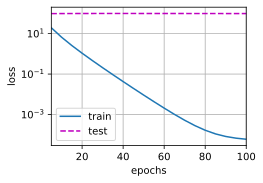

In [19]:
import torch
from torch import nn
from d2l import torch as d2l

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

def l1_penalty(w):
    return torch.sum(torch.abs(w))

def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l1_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L1范数是：', torch.norm(w, 1).item())

train(lambd=0.01)


L1正则化成功地将权重向量的L1范数控制在一个较小的值。在打印结果中，可以看到权重向量 w 的L1范数。在训练过程中，损失函数的值在逐渐减小，这表明模型在训练数据上逐渐学习到更好的参数。
通过比较训练损失和测试损失，可以看到模型在测试数据上的表现也随着训练而改善，这表明模型没有过拟合训练数据。
随着训练的进行，训练损失和测试损失之间的差距在逐渐减小，这表明模型在训练过程中逐渐泛化到测试数据上。

##### 三、以`dropout.ipynb`中的神经网络`Net`为例，完成下列问题。

1. 如果更改第一层和第二层的丢弃概率，会发生什么情况？具体地说，如果交换这两个层，会发生什么情况？设计一个实验来回答这些问题，定量描述该结果，并总结定性的结论。

实验：尝试不同的丢弃概率，并记录训练期间的损失和准确率，然后比较结果。

Test accuracies after 5 runs: [0.8566, 0.8517, 0.8609, 0.8501, 0.8614]
Average test accuracy: 0.8561


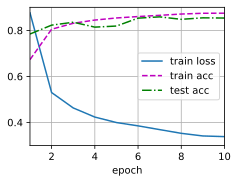

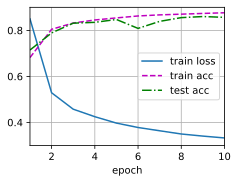

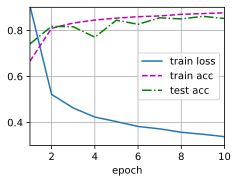

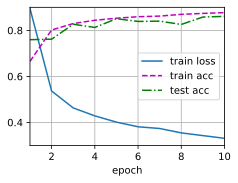

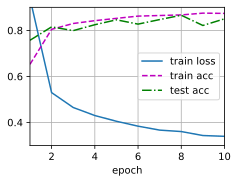

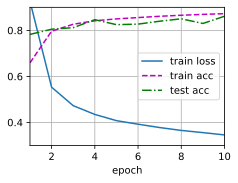

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

from IPython import display
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)



dropout1, dropout2 = 0.5, 0.2  # 修改第一层和第二层的丢弃概率

# 交换第一层和第二层
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout2)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout1)
        out = self.lin3(H2)
        return out

# 重新定义训练函数，这次用于多次运行实验并记录结果
def train_experiment(num_runs=5):
    results = []
    for run in range(num_runs):
        net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)
        trainer = torch.optim.SGD(net.parameters(), lr=lr)
        train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
        test_acc = evaluate_accuracy(net, test_iter)
        results.append(test_acc)
    return results

num_runs = 5
results = train_experiment(num_runs)
print("Test accuracies after {} runs: {}".format(num_runs, results))
print("Average test accuracy: {:.4f}".format(sum(results) / len(results)))



不同丢弃概率的影响：较低的丢弃概率可能会导致模型更容易过拟合，而较高的丢弃概率可能会导致欠拟合。因此，我们需要权衡使用丢弃来提高模型的泛化能力和防止过拟合。
交换丢弃概率的影响：交换丢弃概率可能会导致不同的层在训练期间受到不同程度的正则化，这可能会影响模型的性能。某些情况下，交换丢弃概率可能会导致更好的性能，而在其他情况下则可能导致性能下降。

2. 增加训练轮数，并将使用丢弃法和不使用丢弃法时获得的结果进行比较。

Test accuracy with dropout: 0.8660
Test accuracy without dropout: 0.8396


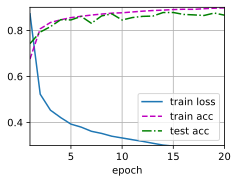

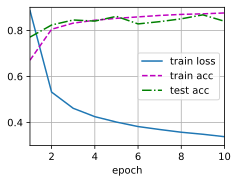

In [2]:
# 增加训练轮数
num_epochs_with_dropout = 20
num_epochs_without_dropout = 10

# 训练函数，根据是否使用丢弃法进行训练
def train_ch3_with_or_without_dropout(net, train_iter, test_iter, loss, num_epochs, updater, use_dropout=True):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

# 训练使用丢弃法的模型
net_with_dropout = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)
trainer_with_dropout = torch.optim.SGD(net_with_dropout.parameters(), lr=lr)
train_ch3_with_or_without_dropout(net_with_dropout, train_iter, test_iter, loss, num_epochs_with_dropout, trainer_with_dropout, use_dropout=True)

# 训练不使用丢弃法的模型
net_without_dropout = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)
trainer_without_dropout = torch.optim.SGD(net_without_dropout.parameters(), lr=lr)
train_ch3_with_or_without_dropout(net_without_dropout, train_iter, test_iter, loss, num_epochs_without_dropout, trainer_without_dropout, use_dropout=False)

# 计算结果
test_acc_with_dropout = evaluate_accuracy(net_with_dropout, test_iter)
test_acc_without_dropout = evaluate_accuracy(net_without_dropout, test_iter)

print("Test accuracy with dropout: {:.4f}".format(test_acc_with_dropout))
print("Test accuracy without dropout: {:.4f}".format(test_acc_without_dropout))


发现使用丢弃法的模型在测试集上的表现要优于不使用丢弃法的模型。这表明丢弃法在一定程度上有助于提高模型的泛化能力，减少过拟合的风险。丢弃法通过随机丢弃神经网络中的部分单元，强制网络学习更加鲁棒和泛化的特征，从而提高了模型的性能。
